# Convolutional Neural Networks

We now apply the MLP to MNIST (handwritten digits). First, we use densely connected networks, as done with non-image data.

Then, we look into using convolutional layers designed for images. Note that because MNIST is an easy data set to classify, the overall performances may be similar.

But there are many benefits of using CNN in images, over densely-connected networks, such as spatial understanding, less parameters, non-diminishing gradients, and others.

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# PyTorch TensorBoard support
# from torch.utils.tensorboard import SummaryWriter
# import torchvision
# import torchvision.transforms as transforms

from datetime import datetime

import torchvision
import torchvision.transforms as transforms

from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F

from PIL import Image
#import torchvision.transforms as T

In [4]:
# load the dataset
fashion_dataset = FashionMNIST(root = 'data/', download=True, train = True, transform = transforms.ToTensor())
print(fashion_dataset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()


torch.Size([1, 28, 28]) 0
tensor([[[0.6510, 0.5961, 0.6196, 0.6196, 0.6275],
         [0.6235, 0.6000, 0.6157, 0.6196, 0.6353],
         [0.6196, 0.6078, 0.6353, 0.6196, 0.6275],
         [0.5961, 0.6275, 0.6196, 0.6314, 0.6275],
         [0.5765, 0.6431, 0.6078, 0.6471, 0.6314]]])
tensor(1.) tensor(0.)


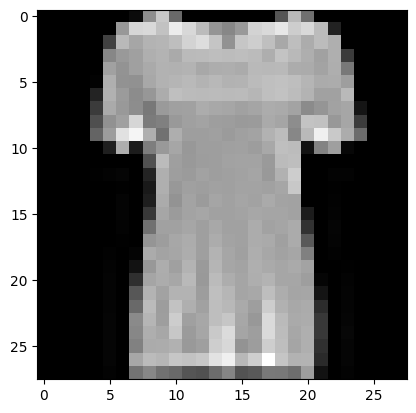

In [5]:
# mnist_dataset has 'images as tensors' so that they can't be displayed directly
sampleTensor, label = fashion_dataset[10]
print(sampleTensor.shape, label)
tpil = transforms.ToPILImage() # using the __call__ to
image = tpil(sampleTensor)
image.show()

# The image is now convert to a 28 X 28 tensor.
# The first dimension is used to keep track of the color channels.
# Since images in the MNIST dataset are grayscale, there's just one channel.
# The values range from 0 to 1, with 0 representing black, 1 white and the values between different shades of grey.
print(sampleTensor[:,10:15,10:15])
print(torch.max(sampleTensor), torch.min(sampleTensor))
plt.imshow(sampleTensor[0,:,:],cmap = 'gray')

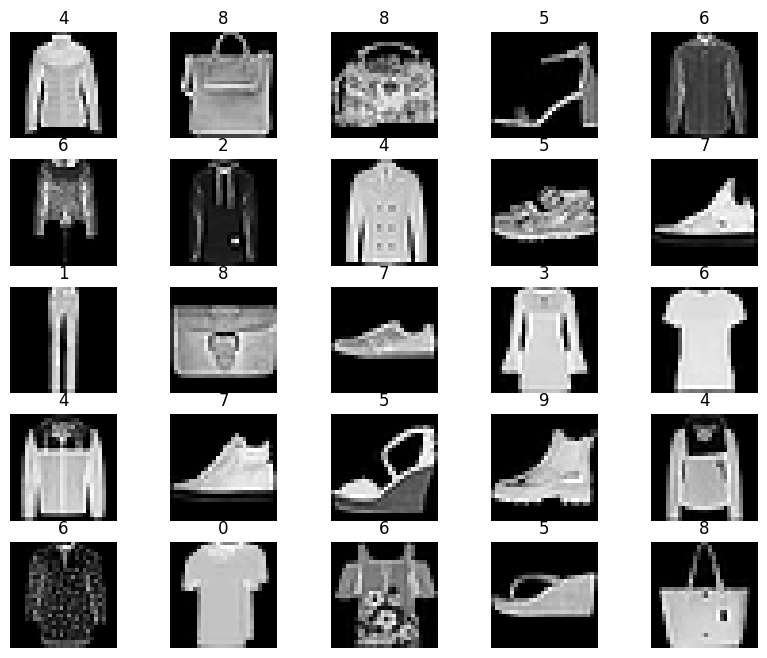

In [6]:
# Print multiple images at once
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(fashion_dataset), size=(1,)).item()
    img, label = fashion_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

tensor([[[0.6510, 0.5961, 0.6196, 0.6196, 0.6275],
         [0.6235, 0.6000, 0.6157, 0.6196, 0.6353],
         [0.6196, 0.6078, 0.6353, 0.6196, 0.6275],
         [0.5961, 0.6275, 0.6196, 0.6314, 0.6275],
         [0.5765, 0.6431, 0.6078, 0.6471, 0.6314]]])
tensor(1.) tensor(0.)


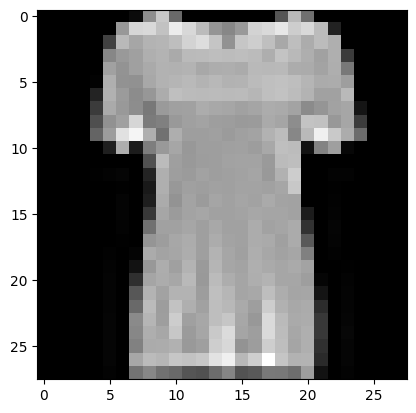

In [7]:
# The image is now convert to a 28 X 28 tensor.
# The first dimension is used to keep track of the color channels.
# Since images in the MNIST dataset are grayscale, there's just one channel.
# The values range from 0 to 1, with 0 representing black, 1 white and the values between different shades of grey.
print(sampleTensor[:,10:15,10:15])
print(torch.max(sampleTensor), torch.min(sampleTensor))
plt.imshow(sampleTensor[0,:,:],cmap = 'gray')

## Training and validation data
While building a ML/DP models, it is common to split the dataset into 3 parts:

*   Training set - to train the model,c ompute the loss and adjust the weights of the model using gradient descent.
*   Validation set - to evalute the traing model, adjusting the hyperparameters and pick the best version of the model.
*   Test set - to final check the model predictions on the new unseen data to evaluate how well the model is performing.

Quite often, validation and test sets are interchanged (i.e., the validation set is used to final check the model predictions...). Read carefully of the setup.

Following adapted from [Kaggle notebook](https://www.kaggle.com/code/geekysaint/solving-mnist-using-pytorch)

In [8]:
train_data, validation_data = random_split(fashion_dataset, [50000, 10000])
## Print the length of train and validation datasets
print("length of Train Datasets: ", len(train_data))
print("length of Validation Datasets: ", len(validation_data))

batch_size = 128
train_loader = DataLoader(train_data, batch_size, shuffle = True)
val_loader = DataLoader(validation_data, batch_size, shuffle = False)
## MNIST data from pytorch already provides held-out test set!

length of Train Datasets:  50000
length of Validation Datasets:  10000


## Multi-class Logistic Regression (a building block of DNN)

Since nn.Linear expects the each training example to a vector, each 1 X 28 X 28 image tensor needs to be flattened out into a vector of size 784(28 X 28), before being passed into the model.

The output for each image is vector of size 10, with each element of the vector signifying the probability a particular target label(i.e 0 to 9). The predicted label for an image is simply the one with the highest probability.

In [9]:
## Basic set up for a logistic regression model (won't be used in practice or for training)
input_size = 28 * 28
num_classes = 10

# we gradually build on this inherited class from pytorch
model = nn.Linear(input_size, num_classes)

We define the class with multiple methods so that we can train, evaluate, and do many other routine tasks with the model.

Particularly, we are looking at multi-class logistic regression (a generalization of one-class logistic regression) using the softmax function (more about this in a few cells down)

In [10]:
# Slowly build the model, first with basic
class FashionMnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        # view xb with two dimensions, 28 * 28(i.e 784)
        # One argument to .reshape can be set to -1(in this case the first dimension),
        # to let PyTorch figure it out automatically based on the shape of the original tensor.
        xb = xb.reshape(-1, 784)
        print(xb)
        out = self.linear(xb)
        print(out)
        return(out)

model = FashionMnistModel()
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[ 0.0105, -0.0297,  0.0006,  ..., -0.0321,  0.0084,  0.0165],
         [-0.0075, -0.0311,  0.0284,  ..., -0.0008,  0.0266, -0.0214],
         [-0.0260, -0.0145, -0.0336,  ..., -0.0270,  0.0293, -0.0141],
         ...,
         [ 0.0214,  0.0191, -0.0323,  ...,  0.0051, -0.0202, -0.0131],
         [ 0.0347,  0.0055, -0.0283,  ..., -0.0106, -0.0047, -0.0044],
         [-0.0202,  0.0231, -0.0273,  ..., -0.0259, -0.0011, -0.0169]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0028,  0.0164,  0.0209,  0.0177,  0.0238, -0.0280, -0.0268,  0.0230,
         -0.0030,  0.0109], requires_grad=True)]

In [11]:
# Alway check the dimensions and sample data/image
for images, labels in train_loader:
    outputs = model(images)
    break

print('Outputs shape: ', outputs.shape) # torch.Size([128, 10])
print('Sample outputs: \n', outputs[:2].data) # example outputs

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[ 0.0791,  0.3090, -0.0901,  ..., -0.2392,  0.2528, -0.0354],
        [ 0.1510,  0.3832, -0.0963,  ..., -0.0352,  0.1005, -0.2518],
        [ 0.3033,  0.5002, -0.2513,  ..., -0.0821,  0.1711, -0.3288],
        ...,
        [ 0.0676,  0.2845, -0.0778,  ...,  0.0333,  0.0537, -0.1141],
        [ 0.0983,  0.3063, -0.1668,  ..., -0.1444,  0.2388, -0.0340],
        [ 0.3084,  0.3004,  0.0919,  ..., -0.3135,  0.1075, -0.3170]],
       grad_fn=<AddmmBackward0>)
Outputs shape:  torch.Size([128, 10])
Sample outputs: 
 tensor([[ 0.0791,  0.3090, -0.0901, -0.4832,  0.1117, -0.2412, -0.0907, -0.2392,
          0.2528, -0.0354],
        [ 0.1510,  0.3832, -0.0963, -0.4165,  0.4200, -0.3754,  0.1695, -0.0352,
          0.1005, -0.2518]])


## Softmax function


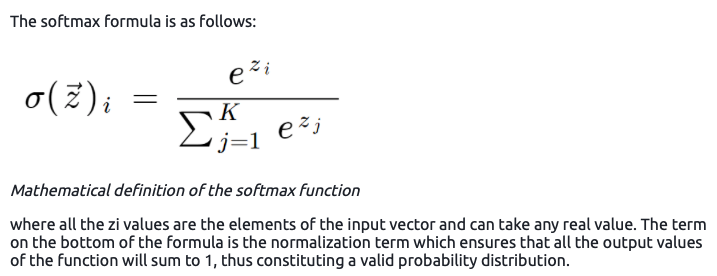

The softmax function is a function that turns a vector of K real values into a vector of K real values that sum to 1. The input values can be positive, negative, zero, or greater than one, but the softmax transforms them into values between 0 and 1, so that they can be interpreted as probabilities. If one of the inputs is small or negative, the softmax turns it into a small probability, and if an input is large, then it turns it into a large probability, but it will always remain between 0 and 1.

The softmax function is sometimes called the softargmax function, or multi-class logistic regression. This is because the softmax is a generalization of logistic regression that can be used for multi-class classification, and its formula is very similar to the sigmoid function which is used for logistic regression. The softmax function can be used in a classifier only when the classes are mutually exclusive.

Many multi-layer neural networks end in a penultimate layer which outputs real-valued scores that are not conveniently scaled and which may be difficult to work with. Here the softmax is very useful because it converts the scores to a normalized probability distribution, which can be displayed to a user or used as input to other systems. For this reason it is usual to append a softmax function as the final layer of the neural network.

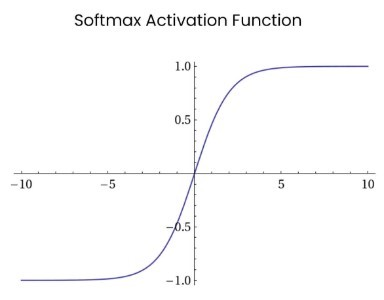

Image from https://insideaiml.com/blog/SoftMaxActivation-Function-1034

In [12]:
## Apply softmax for each output row
probs = F.softmax(outputs, dim = 1)

## chaecking at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

# print(preds)
# print("\n")
# print(max_probs)

Sample probabilities:
 tensor([[0.1101, 0.1385, 0.0929, 0.0627, 0.1137, 0.0799, 0.0929, 0.0801, 0.1310,
         0.0982],
        [0.1114, 0.1405, 0.0870, 0.0632, 0.1458, 0.0658, 0.1135, 0.0925, 0.1059,
         0.0745]])


## Evaluation Metric and Loss Function

Here we evaluate our model by finding the percentage of labels that were predicted correctly i.e. the accuracy of the predictions. We can simply find the label with maximum value (before OR after the softmax layer).

NOTE that while accuracy is a great way to evluate the model, it can't be used as a loss function for optimizing our model using gradient descent, because it does not take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for increemental improvements.

Due to this reason accuracy is a great evaluation metric (and human-understanble) for classification metric, but not a good loss function. A commonly used loss function for classification problems is the Cross Entropy (implemented directly, no extra coding required).

In [13]:
# accuracy calculation
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return(torch.tensor(torch.sum(preds == labels).item()/ len(preds)))

print("Accuracy: ", accuracy(outputs, labels))
print("\n")
loss_fn = F.cross_entropy
print("Loss Function: ",loss_fn)
print("\n")
## Loss for the current batch
loss = loss_fn(outputs, labels)
print(loss)


Accuracy:  tensor(0.0625)


Loss Function:  <function cross_entropy at 0x0000012907CEB100>


tensor(2.3001, grad_fn=<NllLossBackward0>)


## Cross-Entropy
Cross-entropy is commonly used to quantify the difference between two probabilities distribution. Usually the "True" distribution is expressed in terms of a one-hot distribution.

Read more on:


*   https://en.wikipedia.org/wiki/Cross_entropy
*   https://machinelearningmastery.com/cross-entropy-for-machine-learning/
*   https://stackoverflow.com/questions/41990250/what-is-cross-entropy

In [14]:
# We put all of the above:
class FashionMnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return(out)

    # We add extra methods
    def training_step(self, batch):
        # when training, we compute the cross entropy, which help us update weights
        images, labels = batch
        out = self(images) ## Generate predictions
        loss = F.cross_entropy(out, labels) ## Calculate the loss
        return(loss)

    def validation_step(self, batch):
        images, labels = batch
        out = self(images) ## Generate predictions
        loss = F.cross_entropy(out, labels) ## Calculate the loss
        # in validation, we want to also look at the accuracy
        # idealy, we would like to save the model when the accuracy is the highest.
        acc = accuracy(out, labels) ## calculate metrics/accuracy
        return({'val_loss':loss, 'val_acc': acc})

    def validation_epoch_end(self, outputs):
        # at the end of epoch (after running through all the batches)
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return({'val_loss': epoch_loss.item(), 'val_acc' : epoch_acc.item()})

    def epoch_end(self, epoch,result):
        # log epoch, loss, metrics
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

# we instantiate the model
model = FashionMnistModel()

# a simple helper function to evaluate
def evaluate(model, data_loader):
    # for batch in data_loader, run validation_step
    outputs = [model.validation_step(batch) for batch in data_loader]
    return(model.validation_epoch_end(outputs))

# actually training
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        ## Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward() ## backpropagation starts at the loss and goes through all layers to model inputs
            optimizer.step() ## the optimizer iterate over all parameters (tensors); use their stored grad to update their values
            optimizer.zero_grad() ## reset gradients

        ## Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return(history)

In [15]:
# test the functions, with a randomly initialized model (weights are random, e.g., untrained)
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.3524043560028076, 'val_acc': 0.06052215024828911}

In [16]:
# let's train for 10 epochs
history1 = fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.7333, val_acc: 0.6086
Epoch [1], val_loss: 1.4331, val_acc: 0.6617
Epoch [2], val_loss: 1.2615, val_acc: 0.6741
Epoch [3], val_loss: 1.1514, val_acc: 0.6816
Epoch [4], val_loss: 1.0744, val_acc: 0.6937
Epoch [5], val_loss: 1.0173, val_acc: 0.7029
Epoch [6], val_loss: 0.9731, val_acc: 0.7110
Epoch [7], val_loss: 0.9376, val_acc: 0.7215
Epoch [8], val_loss: 0.9083, val_acc: 0.7277
Epoch [9], val_loss: 0.8834, val_acc: 0.7346


Text(0.5, 1.0, 'Accuracy over epochs')

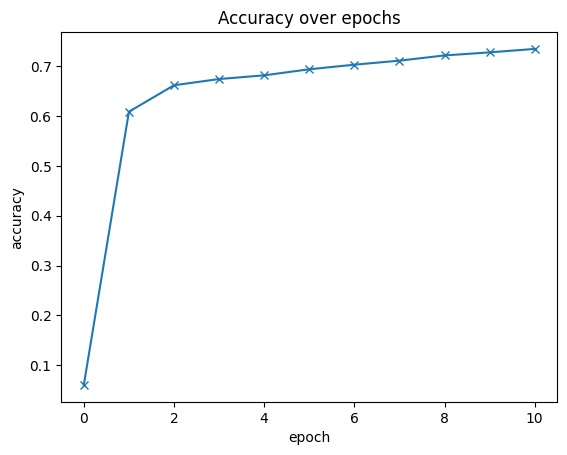

In [17]:
# we combine the first result (no training) and the training results of 5 epoches
# plotting accuracy
history = [result0] + history1
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy over epochs')

Text(0.5, 1.0, 'Losses  over epochs')

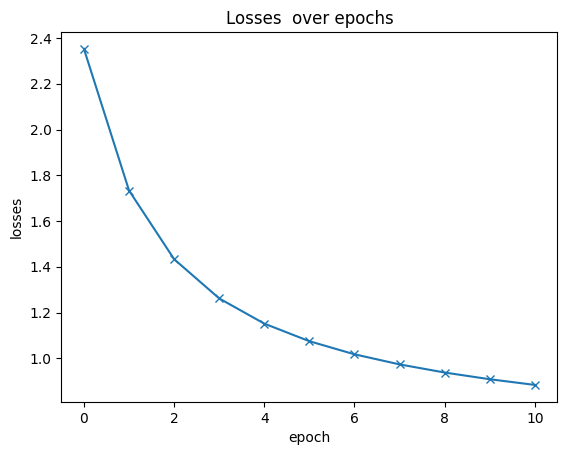

In [18]:
# plotting losses
history = [result0] + history1
losses = [result['val_loss'] for result in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Losses  over epochs')

## Final check using the (held-out) test dataset.

We will first load the test dataset (from MNIST) and individually check the prediction made by the model. And then, we will put through all images in the test dataset to obtain the final accuracy

Length of Test Datasets:  10000
Shape:  torch.Size([1, 28, 28])
Label:  9


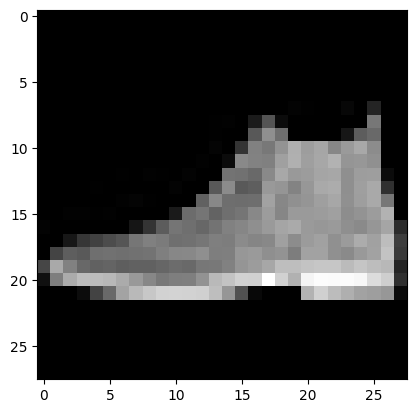

In [19]:
# Testing with individual images
## Define the test dataset
test_dataset = FashionMNIST(root = 'data/', train = False, transform = transforms.ToTensor())
print("Length of Test Datasets: ", len(test_dataset))
img, label = test_dataset[0]
plt.imshow(img[0], cmap = 'gray')
print("Shape: ", img.shape)
print('Label: ', label)

In [20]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim = 1)
    return(preds[0].item())

In [21]:
img, label = test_dataset[0]
print('Label:', label, ', Predicted :', predict_image(img, model))

Label: 9 , Predicted : 9


In [22]:
# the final check on the test dataset (not used in any training)
test_loader = DataLoader(test_dataset, batch_size = 256, shuffle = False)
result = evaluate(model, test_loader)
result

{'val_loss': 0.8979389071464539, 'val_acc': 0.715136706829071}

# Convolutional Neural Network (CNN)
So far we treated the MNIST data by flatting each image into a vector. However, there's a lot of information embedded in spatial information. In order to fully `understand' the image, we need to consider its 2 or more dimensions. Convolutional layers help us in this regard. In most of cases, CNN outperforms densely connected networks and is the most popular architecture for imaging analysis.

CNN is the main force behind revolutionizing the AI or deep learning in the recent decade. Deep neural networks using CNN has shown unprecedented performances when they were first introduced at many competitions (e.g., the ImageNet) by large margins. For imaging analysis, CNN remains the mainstay.

Looking ahead, there are more recent architectures such as the transformer and the diffusion model. We won't be convering them in this course ;)

Convolutional layer is implemented in pytorch as **nn.Conv2d**. As you can see, it is essentially a drop in replacement for nn.Linear and other classes.

The explanation for the pytorch class **nn.Conv2d**.

in_channels (int) — Number of channels in the input image, 1 for a grayscale image

out_channels (int) — Number of channels produced by the convolution

kernel_size (int or tuple) — Size of the convolving kernel

stride (int or tuple, optional) — Stride of the convolution. Default: 1

padding (int or tuple, optional) — Zero-padding added to both sides of the input. Default: 0

padding_mode (string, optional) — ‘zeros’, ‘reflect’, ‘replicate’ or ‘circular’. Default: ‘zeros’

dilation (int or tuple, optional) — Spacing between kernel elements. Default: 1

groups (int, optional) — Number of blocked connections from input channels to output channels. Default: 1

bias (bool, optional) — If True, adds a learnable bias to the output. Default: True

Adapted from [@nutanbhogendrasharma](https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118)



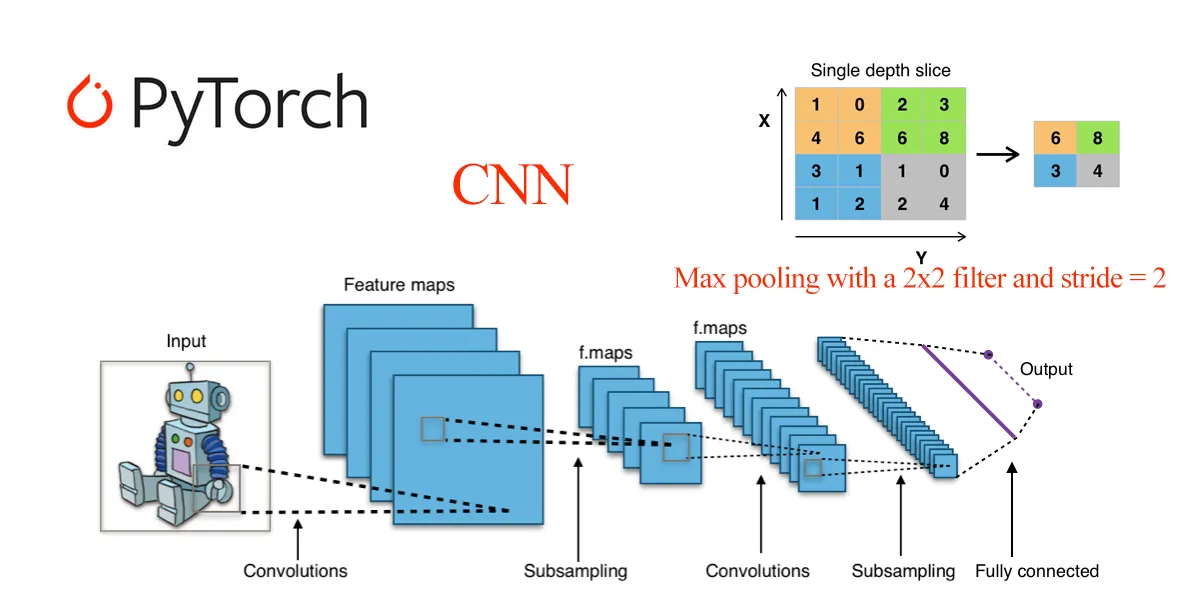

In [23]:
# Original CNN class
# We construct a fundamental CNN class.
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization

cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [31]:
# First modification
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.dropout = nn.Dropout(0.5)
        self.out = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        output = self.out(x)
        return output, x

cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


In [44]:
# Second modification 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        output = self.out(x)
        return output, x

cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (out): Linear(in

In [55]:
# Third modification 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.5)
        self.out = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        output = self.out(x)
        return output, x

cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)


In [56]:
loss_func = nn.CrossEntropyLoss()
loss_func

# unlike earlier example using optim.SGD, we use optim.Adam as the optimizer
# lr(Learning Rate): Rate at which our model updates the weights in the cells each time back-propagation is done.
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [57]:
# train_data, validation_data = random_split(mnist_dataset, [50000, 10000])
# ## Print the length of train and validation datasets
# print("length of Train Datasets: ", len(train_data))
# print("length of Validation Datasets: ", len(validation_data))

# batch_size = 128
# train_loader = DataLoader(train_data, batch_size, shuffle = True)
# val_loader = DataLoader(validation_data, batch_size, shuffle = False)
from torch.autograd import Variable

def train(num_epochs, cnn, loaders):
    cnn.train()
    optimizer = optim.Adam(cnn.parameters(), lr = 0.01)
    loss_func = nn.CrossEntropyLoss()
    # Train the model
    total_step = len(loaders)

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders):

            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)

            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                pass
        pass
    pass

In [58]:
# instiate the CNN model
cnn = CNN()
# for testing purpose, we calculate the accuracy of the initial
cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        test_output, last_layer = cnn(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        pass
print('Accuracy of the model on the 10000 test images: %.2f' % accuracy)


Accuracy of the model on the 10000 test images: 0.14


In [59]:
train(num_epochs=5, cnn=cnn, loaders=train_loader)

Epoch [1/5], Step [100/391], Loss: 0.8475
Epoch [1/5], Step [200/391], Loss: 0.6943
Epoch [1/5], Step [300/391], Loss: 0.8732
Epoch [2/5], Step [100/391], Loss: 0.6510
Epoch [2/5], Step [200/391], Loss: 0.4963
Epoch [2/5], Step [300/391], Loss: 0.4846
Epoch [3/5], Step [100/391], Loss: 0.4807
Epoch [3/5], Step [200/391], Loss: 0.5818
Epoch [3/5], Step [300/391], Loss: 0.5953
Epoch [4/5], Step [100/391], Loss: 0.5953
Epoch [4/5], Step [200/391], Loss: 0.5033
Epoch [4/5], Step [300/391], Loss: 0.6526
Epoch [5/5], Step [100/391], Loss: 0.5837
Epoch [5/5], Step [200/391], Loss: 0.4423
Epoch [5/5], Step [300/391], Loss: 0.4480


# Evaluate the model on test data

We must call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. model.train() set layers like dropout, batchnorm etc. to behave for training.

You can call either model.eval() or model.train(mode=False) to tell that you are testing the model.

In [60]:
# Test the model, after the training
cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        test_output, last_layer = cnn(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        pass
print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)


Test Accuracy of the model on the 10000 test images: 0.89


In [61]:
# Test the model, after the training
cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        test_output, last_layer = cnn(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        pass
print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)


Test Accuracy of the model on the 10000 test images: 0.81


Run inference on individual images

In [39]:
sample = next(iter(test_loader))
imgs, lbls = sample

actual_number = lbls[:10].numpy()
actual_number

test_output, last_layer = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [9 2 1 1 6 1 4 6 5 7]
Actual number: [9 2 1 1 6 1 4 6 5 7]


## Fashion MNIST (Homework dataset)


The MNIST dataset is not too demanding, let's try something a little more difficult - Fashion MNIST.

[LINK TO IMAGE](https://s3-eu-central-1.amazonaws.com/zalando-wp-zalando-research-production/2017/08/fashion-mnist-sprite.png)

Check out labels on [GitHub](https://github.com/zalandoresearch/fashion-mnist):

# **HOMEWORK 1**
Build a classifier for fashion MNIST.

**1. Use exactly the same architectures (both densely connected layers and from convolutional layers) as the above MNIST** e.g., replace the dataset. Save the Jupyter Notebook in its original format and output a PDF file after training, testing, and validation. Make sure to write down how do they perform (training accuracny, testing accuracy).  
**2. Improve the architecture**. Experiment with different numbers of layers, size of layers, number of filters, size of filters. You are required to make those adjustment to get the highest accuracy. Watch out for overfitting -- we want the highest testing accuracy!
Please provide a PDF file of the result, the best test accuracy and the architecture (different numbers of layers, size of layers, number of filters, size of filters)

In [ ]:
''' 
Original CNN class:
Training accuracy 0.89
Testing accuracy 0.88

First modification on CNN class:
Training accuracy 0.88
Testing accuracy 0.88

Second modification on CCN class:
Training accuracy 0.90
Testing accuracy 0.94

Third modification on CNN class:
Training accuracy 0.89
Testing accuracy 0.81
'''

In [ ]:
### Best CNN class ###

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        output = self.out(x)
        return output, x

cnn = CNN()
print(cnn)